In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle

In [4]:
def upload_dataset_with_time(path:str):
    startingT = time.perf_counter()
    veriseti = pd.read_csv(path, low_memory=False)
    endingT = time.perf_counter()
    print(f"Dataset is loaded in {endingT - startingT} seconds")
    return veriseti

data_path = 'ddos_dataset_on_seconds.csv'
syn_benign_df = upload_dataset_with_time(data_path)

Dataset is loaded in 0.23830050000000114 seconds


In [7]:
ntp_path = 'ntp_by_seconds_data.csv'
ntp_df = upload_dataset_with_time(ntp_path)

def label_ddos(label:int):
    if label > 20:
        return 1
    else:
        return 0
ntp_df["Label"] = ntp_df["Label"].apply(lambda x: label_ddos(x))
ddos_ntp = ntp_df[ntp_df["Label"] == 1].sample(524).reset_index(drop=True)
ddos_ntp = ddos_ntp[[*(syn_benign_df.columns)]]

Dataset is loaded in 0.023355500000000973 seconds


In [8]:
syn_slice_1 = syn_benign_df.iloc[:12000, :].copy()
syn_slice_2 = syn_benign_df.iloc[12000:, :].copy()
merged_df = pd.concat([syn_slice_1, ddos_ntp ,syn_slice_2, ddos_ntp, syn_slice_2], axis = 0).reset_index(drop=True)
df = merged_df.copy()

In [127]:
import pandas as pd
import numpy as np
import stumpy
import random

class MatrixProfileManager:
    if 'global_df' not in dir():
        global_df = None

    THRESHOLD_BASE_ACTIVE = False
    threshold = 5.0

    def __init__(self, df:pd.DataFrame, window_size:int = 60, discord_number = 476, method='mpx', measure='acc'):
        self.measurement = measure
        self.window_size = window_size
        self.discord_number = discord_number
        self.discord_dict = {}
        self.discords = []
        self.df = df
        self.mp_method = method
        self.curr_mp_dict = {}

    def calculate_mp_multivariate_stumpy(self):
        curr_mps, curr_indices = stumpy.mstump(self.df, self.window_size)
        self.mps = curr_mps

    def calculate_mp_seperately_mpx(self):
        import matrixprofile as mp
        mp_list = []
        
        for ft in self.df.columns:
            inputSignal = self.df[ft].to_list()
            matrix_profile = mp.compute(inputSignal, windows=self.window_size, threshold=0.95, n_jobs=4)
            mp_list.append(matrix_profile['mp'])

        self.mps = np.array(mp_list)
    
    def calculate_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        curr_mps_dict = {f_idx: np.argsort(self.mps[idx])[::-1][:1000] for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:self.discord_number] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))
            #sort the indices by count
            if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE == True):
                sorted_discord_indexes = indice_list.copy()
            else:
                sorted_discords = sorted(Counter(indice_list).items(), key=lambda t:t[1], reverse=True)
                sorted_discord_indexes = [elem[0] for elem in sorted_discords[:self.discord_number]]

            self.discord_dict[idx] = sorted_discord_indexes

    def majority_vote_discords(self):
        from collections import Counter
        overall_list = []
        for ft, ids_list in self.discord_dict.items():
            overall_list.extend(ids_list)

        if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE):
            self.discords = list(set(overall_list))
        else:
            sorted_overall = (sorted(Counter(overall_list).items(), key=lambda t:t[1], reverse=True))
            self.discords = [elem[0] for elem in sorted_overall[:self.discord_number]]


    def obtain_y_vals(self):
        df_idxs = list(range(0, len(MatrixProfileManager.global_df)))
        for idx in self.discords:
            try:
                df_idxs.remove(idx)
            except:
                print(f"idx : {idx} not found in global df indexes.")
  
        
        self.pred_df = pd.DataFrame()
        self.pred_df['y_true'] = MatrixProfileManager.global_df["Label"].copy()
        self.pred_df["y_pred"] = MatrixProfileManager.global_df["Label"].copy()
        
        self.pred_df.iloc[df_idxs, 1] = 0
        self.pred_df.iloc[self.discords, 1] = 1

    def calculate_classification_report(self):
        from sklearn.metrics import classification_report
        if 'y_true' not in self.pred_df.columns:
            raise ValueError('true vals not included in df')

        if 'y_pred' not in self.pred_df.columns:
            raise ValueError('pred vals not included in df')

        self.creport = classification_report(self.pred_df["y_true"].to_list(),
                                             self.pred_df["y_pred"].to_list(), output_dict=True)["1"]

    def get_f1_score(self):
        if self.creport is None:
            raise ValueError('Classification Report is not ready!')
            
        return self.creport['f1-score']

    def get_mp_score(self):
        #maximize this
        return sum([sum(mp_score) for mp_score in self.curr_mp_dict.values()]) / len(self.curr_mp_dict.keys())

    def calculate_cost(self):
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()
        
        self.calculate_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score

    def calculate_thresholded_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        threshold = MatrixProfileManager.threshold
        curr_mps_dict = {f_idx: np.where(self.mps[idx] > threshold)[0].tolist() for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:10] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))

            if (MatrixProfileManager.THRESHOLD_BASE_ACTIVE):
                self.discord_dict[idx] = list(set(indice_list))
            else:
                AssertionError("wrong func!")

    def calculate_threshold_based_cost(self):    
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()

        self.calculate_thresholded_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score


class GeneticAlgo:
    verbosity_level = 0
    thresholded_mp = False
    def __init__(self, df:pd.DataFrame, max_features:int, population_bag_size:int = 3, fitness = 'MP'):
        print('Genetic Algorithm Process is ready to start')
        self.df = df.copy()
        self.y = df[["Label"]]
        self.X = df.drop(["Label"], axis = 1)
        self.feature_map = {i : feat_name for i, feat_name in enumerate(self.X.columns)}
        self.X.columns = list(range(0, len(self.X.columns)))
        self.feature_number = max_features
        self.pop_bag_size = population_bag_size
        self.creport = None
        self.eval_result = None
        self.fitness_type = fitness
        

    def initialize_population(self):
        self.population_bag = []
        for _ in range(self.pop_bag_size):
            #0 veya 1 atiyoruz feature pick or not pick, 1 olanlari appendliyoruz.
            genes = [random.randrange(0,2) for _ in range(self.feature_number)]
            gene_indexes = [idx for idx, f in enumerate(genes) if f == 1]
            if (len(gene_indexes) == 0):
                gene_indexes.append(random.randint(1,self.feature_number))

            self.population_bag.append(self.X.iloc[:, gene_indexes])

        return self.population_bag

    def create_population(self, pop_bag) -> pd.DataFrame:
        self.population_bag.clear()
        for elem in pop_bag:
            self.population_bag.append(self.X.iloc[:, elem])
            
        return self.population_bag

    def fitness_function(self, individual:pd.DataFrame):
        if (GeneticAlgo.thresholded_mp == True):
            MatrixProfileManager.THRESHOLD_BASE_ACTIVE = True
        else:
            MatrixProfileManager.THRESHOLD_BASE_ACTIVE = False

        mp_manager = MatrixProfileManager(individual, window_size=60, discord_number=1000, method='mpx', measure='f1')
        if (GeneticAlgo.thresholded_mp == False):
            cost, f1_score = mp_manager.calculate_cost()
        elif (GeneticAlgo.thresholded_mp == True):
            cost, f1_score = mp_manager.calculate_threshold_based_cost()
            
        if (GeneticAlgo.verbosity_level < 2):
            print(f'processing solution: {individual.columns.to_list()}')
            print(f"f1-score is: {mp_manager.get_f1_score()}")
        #return f1score instead of cost in order to maximize f1-score:
        
        # return cost, f1_score
        del mp_manager
        return cost, f1_score

    def eval_fit_population(self, pop_bag):
        #This evaluation is based on minimizing the cost!
        result = {}
        fit_vals_lst = []
        f1_score_lst = []
        solutions = []
        for individual in pop_bag:
            if (type(individual) != pd.DataFrame):
                assert(True)

            cost, f1_sc = self.fitness_function(individual.copy())
            fit_vals_lst.append(cost)
            f1_score_lst.append(f1_sc)
            solutions.append(individual.columns.to_list())
            
        result["fit_vals"] = fit_vals_lst
        result["f1-scores"] = f1_score_lst 
        if self.fitness_type == "MP":
            min_wgh = [abs(np.min(list(result['fit_vals'])) - i) for i in list(result['fit_vals'])]
        else:
            min_wgh = [abs(np.min(list(result['f1-scores'])) - i) for i in list(result['f1-scores'])]
        
        from scipy.special import logsumexp
        result["fit_wgh"]  = [i/logsumexp(min_wgh) for i in min_wgh]
        result["solution"] = np.array(solutions, dtype=list).tolist()
        
        self.eval_result = result.copy()
        return result

    def find_best(self, eval_result:dict)->dict:
        # Best individual so far
        best_fit = np.max(eval_result["fit_vals"])
        best_fit_index = eval_result["fit_vals"].index(best_fit)
        best_solution  = eval_result["solution"][best_fit_index]
        f1_sc = eval_result["f1-scores"][best_fit_index]
        print(f'best fit: {best_fit}\nsolution: {best_solution}\nf1Score: {f1_sc}')
        return {'best_fit': best_fit, 'index' : best_fit_index,
                 'solution': best_solution, 'f1-score' : f1_sc}

    def pick_one(self, pop_bag):
        
        if self.eval_result is None:
            eval_result = self.eval_fit_population(pop_bag)
        else:
            eval_result = self.eval_result

        notPicked=True
        cnt = 0
        pickedSol = list()
        while (notPicked == True):
            rnIndex = random.randint(0, len(pop_bag)-1)
            rnPick  = eval_result["fit_wgh"][rnIndex]
            r = random.random()
            if  r <= rnPick:
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            if (cnt > 250):
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            cnt += 1

        return pickedSol

    def crossover(self, solA, solB):
        
        n     = len(solA)
        child: list = []

        num_els = random.randint(0, self.feature_number)
        str_pnt = random.randint(0, max(0,n-3))
        end_pnt = n if int(str_pnt+num_els) > n else int(str_pnt+num_els)

        blockA = list(solA[str_pnt:end_pnt])
        child = blockA.copy()

        for elem in solB:
            if len(child) >= num_els:
                break
            if elem not in blockA:
                child.append(elem)  

        if (len(child) < 1):
            return solA

        return child

    def mutation(self,sol):
        
        # n = len(sol)
        # pos_1 = random.randint(0,n-1)
        # pos_2 = random.randint(0,n-1)
        # result = self.swap(sol, pos_1, pos_2)
        if (len(sol) > 2):
            rd_idx = random.randint(0, len(sol) - 1)
            del sol[rd_idx]
        return sol

    def swap(self,sol, posA, posB):
        result = sol.copy()
        elA = sol[posA]
        elB = sol[posB]
        result[posA] = elB
        result[posB] = elA
        return result

In [54]:
def plot_ddos(df: pd.DataFrame):
    xAxis = list(range(len(df)))
    yAxis = df["Label"].to_list()
    # Create a figure
    fig = plt.figure(figsize=(25,15))
    # Add a subplot
    ax = fig.add_subplot()

    ax.plot(xAxis, yAxis)
    rect = Rectangle((7200, 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    rect = Rectangle((12000, 0), 524, 1, facecolor='red')
    ax.add_patch(rect)
    rect = Rectangle((12524 + 6238 , 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    rect = Rectangle((12000 + 13676 + 524, 0), 524, 1, facecolor='red')
    ax.add_patch(rect)
    rect = Rectangle((12000 + 13676 + 524 + 524 + 6238, 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    plt.ylabel('Label')
    plt.xlabel('Minute')
    plt.title('Network Traffic')
    plt.show()

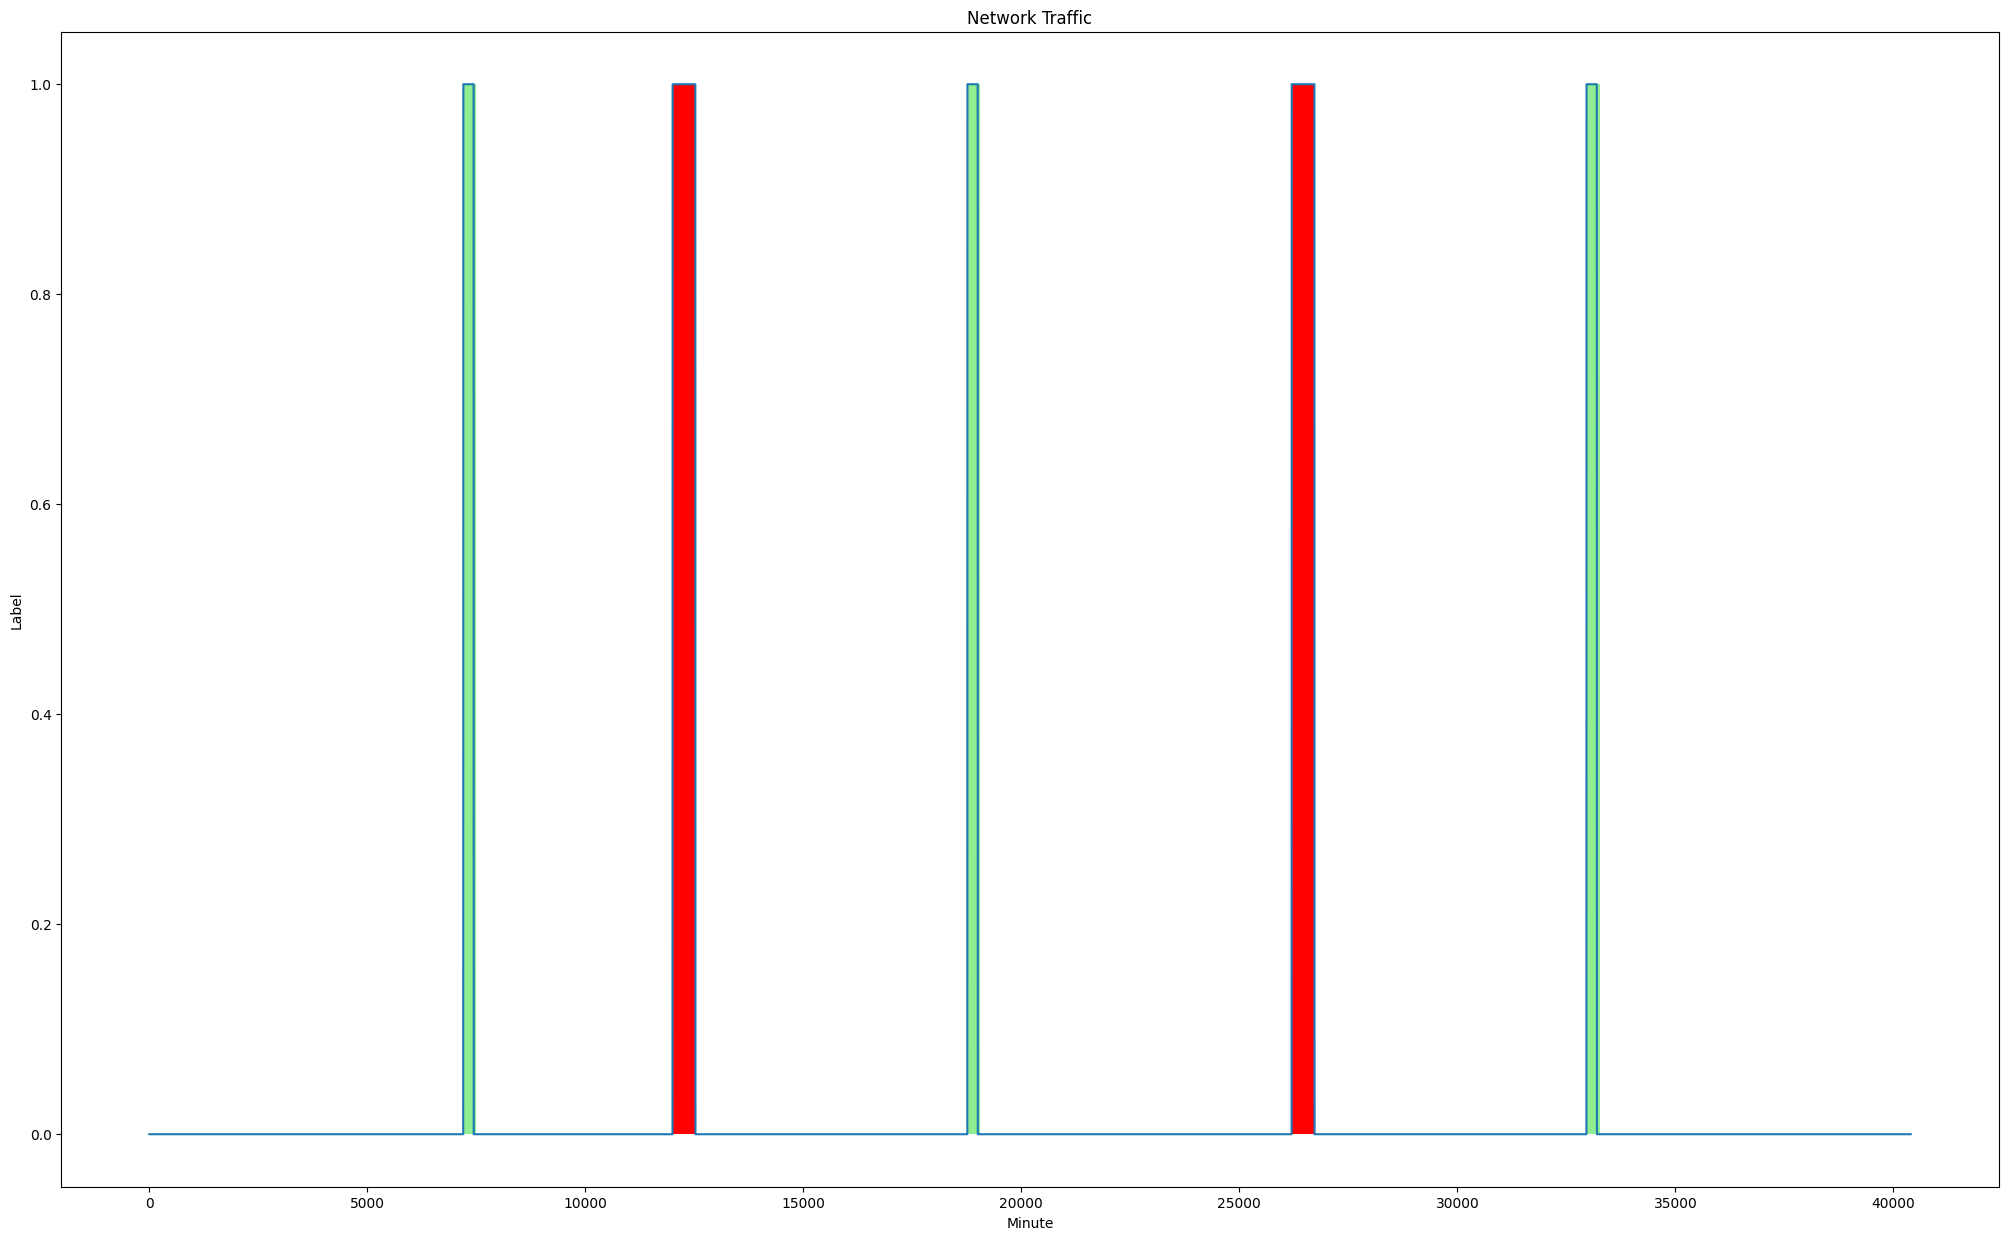

In [55]:
plot_ddos(df)

In [274]:
MatrixProfileManager.global_df = df.copy()

In [319]:
mp_manager = MatrixProfileManager(df.iloc[:,[35, 0, 1, 2, 3]], window_size=60, discord_number=1000, method='mpx', measure='f1')
mp_manager.calculate_mp_seperately_mpx()

In [320]:
mp_dict = {}
for i in range(0, len(mp_manager.mps)):
    print(i)
    mp_dict[f"mp_{i}"] =  np.log10((1 + mp_manager.mps[i])).tolist()

0
1
2
3
4


In [321]:
mp_df = pd.DataFrame(mp_dict)
mp_df

,mp_0,mp_1,mp_2,mp_3,mp_4
0,0.0,0.0,0.0,0.0,7.089164e-08
1,0.0,0.0,0.0,0.0,7.089164e-08
2,0.0,0.0,0.0,0.0,0.000000e+00
3,0.0,0.0,0.0,0.0,0.000000e+00
4,0.0,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...
40336,0.0,0.0,0.0,0.0,0.000000e+00
40337,0.0,0.0,0.0,0.0,0.000000e+00
40338,0.0,0.0,0.0,0.0,0.000000e+00
40339,0.0,0.0,0.0,0.0,0.000000e+00


In [322]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [323]:
model=IsolationForest()
model.fit(mp_df.iloc[:,:])

IsolationForest()

In [324]:
mp_df['scores']=model.decision_function(mp_df.iloc[:,:])
mp_df['anomaly']=model.predict(mp_df.iloc[:, :-1])

In [325]:
anomaly_list = mp_df[mp_df["anomaly"] == -1].index.to_list()
mp_manager.discords = anomaly_list.copy()

In [326]:
mp_manager.obtain_y_vals()
mp_manager.calculate_classification_report()
print(mp_manager.creport)

{'precision': 0.8744416873449131, 'recall': 1.0, 'f1-score': 0.933015620863119, 'support': 1762}


In [327]:
len(anomaly_list)

2015

In [328]:
single_iso_forest_df = df.iloc[:,[35, 0, 1, 2, 3]]
model_2=IsolationForest()
model_2.fit(single_iso_forest_df)

IsolationForest()

In [329]:
single_iso_forest_df['scores']= model_2.decision_function(single_iso_forest_df.iloc[:,:])
single_iso_forest_df['anomaly']= model_2.predict(single_iso_forest_df.iloc[:,:-1])

C:\Users\batuh\AppData\Local\Temp\ipykernel_3220\2535274755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_iso_forest_df['scores']= model_2.decision_function(single_iso_forest_df.iloc[:,:])
C:\Users\batuh\AppData\Local\Temp\ipykernel_3220\2535274755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_iso_forest_df['anomaly']= model_2.predict(single_iso_forest_df.iloc[:,:-1])


In [331]:
anomaly_list = single_iso_forest_df[single_iso_forest_df["anomaly"] == -1].index.to_list()
print(len(anomaly_list))

14641


In [332]:
true_label_list = df[df["Label"] == 1].index.to_list()

In [333]:
y_pred_df = df.copy()
y_pred_df["y_pred"] = np.zeros(len(df))
y_pred_df.iloc[anomaly_list, -1] = 1

In [334]:
from sklearn.metrics import classification_report

In [335]:
print(classification_report(y_pred_df["Label"].to_list(), y_pred_df["y_pred"].to_list()))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     38638
           1       0.12      1.00      0.21      1762

    accuracy                           0.68     40400
   macro avg       0.56      0.83      0.51     40400
weighted avg       0.96      0.68      0.77     40400



In [66]:
import mp_genetic_utils
import pandas as pd



import random as rnd
MatrixProfileManager.THRESHOLD_BASE_ACTIVE = True
MatrixProfileManager.global_df = df.copy()
MatrixProfileManager.threshold = 8
GeneticAlgo.thresholded_mp = True
genetic_algo = GeneticAlgo(df.copy(), max_features=38, population_bag_size=10, fitness="F1")
pop_bag = genetic_algo.initialize_population()
generation_number = 1
for generation in range(generation_number):
    print(f"Generation {generation} is started!")
    
    res = genetic_algo.eval_fit_population(pop_bag)
    best_fit, _, best_solution, f1_score = genetic_algo.find_best(res).values()
    
    if (generation == 0):
        best_fit_global      = best_fit
        best_solution_global = best_solution
        best_f1_global = f1_score
    else:
        if (f1_score >= best_f1_global):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global = f1_score

    new_pop_bag = []
    for i in range(len(genetic_algo.population_bag)):
                # Pick 2 parents from the bag
        pA = genetic_algo.pick_one(pop_bag)
        pB = genetic_algo.pick_one(pop_bag)
        new_element = pA
            # Crossover the parents
        if rnd.random() <= 0.87:
            new_element = genetic_algo.crossover(pA, pB)
            # Mutate the child
        if rnd.random() <= 0.5:
            new_element = genetic_algo.mutation(new_element) 
        new_pop_bag.append(new_element)
            # Set the new bag as the population bag
    pop_bag = genetic_algo.create_population(new_pop_bag)

print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {f1_score}")


FileNotFoundError: [Errno 2] No such file or directory: '../verisetleri/ddos_dataset_on_seconds.csv'

In [48]:
random.randint(0, 3)

3

In [35]:
a_list = list(range(0, len(MatrixProfileManager.global_df)))

In [37]:
len(mp_manager.discords)

635

Genetic Algorithm Process is ready to start


In [42]:
gA = GeneticAlgo(df.copy(), max_features=10, population_bag_size=5, fitness="F1")
first_pop = gA.initialize_population()

MatrixProfileManager.THRESHOLD_BASE_ACTIVE = True
MatrixProfileManager.global_df = df.copy()
MatrixProfileManager.threshold = 5

for pop in first_pop:
    mp_deneme_manager = MatrixProfileManager(pop, window_size=60, discord_number=1000, method='mpx', measure='f1')
    cost, f1_score = mp_deneme_manager.calculate_threshold_based_cost()

Genetic Algorithm Process is ready to start
threshold based discords
threshold based discords
threshold based discords
threshold based discords
threshold based discords
